<h1>Figure 1</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log

<h2>Data sources</h2>
<p>Protein sequences for all <i>S. cerevisiae</i> genes were downloaded from <a href="https://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/" target=_blank>SGD</a> (file 'orf_coding.fasta.gz'). Codon decoding times are from <a href="" target=_blank>Chu <i>et al.</i> 2014</a>. </p>
<h2>Computation of decoding times and decoding time percentiles</h2>
<p>Computations were performed using the R script '<a href="http://localhost:8888/view/Dropbox/root/Papers%20in%20Progress/Kazana%20et%20al/GitHub/Figure%201/speedpercentiles.R" target=_blank>speedpercentiles.r</a>', which looks up the decoding times for the first ten codons of each gene and sums them. The script then generates random sequences coding for the same protein sequence as the original, using the <i>permutation</i> function from <a href="https://cran.r-project.org/web/packages/seqinr/index.html" target=_blank>seqinR</a>, with equal weights for all codons as specified in the file '<a href="http://localhost:8888/view/Dropbox/root/Papers%20in%20Progress/Kazana%20et%20al/GitHub/Figure%201/uniweight.RData" target=_blank>uniweight.RData</a>'. The decoding times of all permutations are ranked, and the actual decoding time is compared to this ranked list to arrive at a speed percentile (the proportion of sequences that is faster than the actual sequence). The ranking procedure was done iteratively to ensure that sufficient number of rnadom sequences were generated to compare the rank reliably.</p>
<p>Speed percentiles were converted to <i>P</i>  by calculating the log10 of the percentile for percentiles smaller than 0.5, and the log10 of (1-percentile) for log10 greater than 0.5 (thus <i>P</i> is a log cale measure of the number of sequences that are more extreme than the observed sequence).</p>
<p>The output from this procedure is stored in file <a href="http://localhost:8888/view/Dropbox/root/Papers%20in%20Progress/Kazana%20et%20al/GitHub/Figure%201/firstTenNew.csv" target=_blank>firstTenNew.csv</a></p>

In [2]:
dataset = pd.read_csv('firstTenNew.csv')

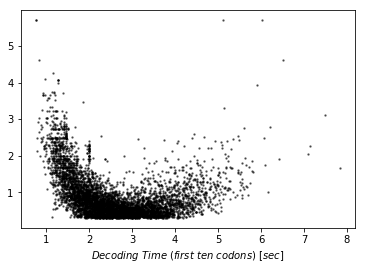

In [3]:
#y axis label setting does not work properly in our version of jupyter notebook. 
#The figure for the publication was produced in Spyder with the commented line out-commented.
plt.scatter(dataset['DecodingTime'], dataset['P'],color='black',alpha=0.5,s=2)
plt.xlabel('$Decoding\ Time\ (first\ ten\ codons)\ [sec]$')
#plt.ylabel(r'$Probability\ [log_{10}]$')
#plt.savefig('volcano.svg')
plt.show()


<h2>Protein abundance analyses</h2>
<p>Protein abundance data were retrieved from the curated dataset by <a href="https://www.ncbi.nlm.nih.gov/pubmed/29361465" target=_blank>Ho <i>et al.</i> 2018</a> ("median molecules" from supplemental <a href = "http://brown.biochemistry.utoronto.ca/ho_et_al_data/TableS4_Final.xlsx" target=_blank>table 4</a>). The cells below add the abundance data to the speed table, and calcuate the abundance for the fastest, slowest, and central 250 sequences.</p>

In [4]:
proteins_per_cell = pd.read_csv('Ho_2018_protein_abundance.csv')

protein_abundance = []
#look up the abundance values for eahc gene in table 'dataset'. If no protein abudnance is specified 
#or the gene ename does not exist in the Ho dataset, assign a protein abudnance of zero.
for gene in dataset['ORF'].values:
    if gene in proteins_per_cell['Systematic Name'].values:
        this_abundance = proteins_per_cell['Median molecules per cell'].loc[proteins_per_cell['Systematic Name']==gene].reset_index(drop=True)[0]
        if this_abundance > 0:
            protein_abundance.append(log(this_abundance,10))
        else:
            protein_abundance.append(0)
    else:
        protein_abundance.append(0)

dataset['log_protein_abundance'] = protein_abundance


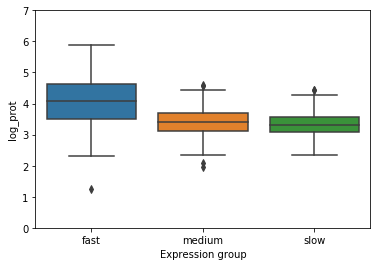

In [5]:
#investigate whether the top, bottom and middle 250 genes have particular expression properties

#remove all entires for which protein expresison is zero
dataset_no_zeros = dataset.loc[dataset['log_protein_abundance'] > 0]

#sort dataframe by first ten decoding speed
dataset_sorted = dataset_no_zeros.sort_values(['DecodingTime']).reset_index(drop=True)

#isolate the first, last, and central 250 rows
fastest_250 = dataset_sorted.head(250)
slowest_250 = dataset_sorted.tail(250)
middle_start = int(dataset_sorted.shape[0]/2 - 125)
middle_stop = int(dataset_sorted.shape[0]/2 + 125)
middle_250 = dataset_sorted.iloc[middle_start:middle_stop]

#isolate the protein expression values and make single dataframe holding the values and the three class names
factor_fast = ['fast'] * 250
factor_medium = ['medium'] * 250
factor_slow = ['slow'] * 250
factors = factor_fast + factor_medium + factor_slow
values_fast = list(fastest_250['log_protein_abundance'])
values_medium = list(middle_250['log_protein_abundance'])
values_slow = list(slowest_250['log_protein_abundance'])
values = values_fast + values_medium + values_slow
expression_groups = pd.DataFrame({'group': factors, 'log_prot': values})

#make a boxplot of the data
plt.close()
sns.color_palette('colorblind')
sns.boxplot(x='group', y='log_prot', data=expression_groups)
plt.ylim(0,7)
plt.xlabel('Expression group')
#plt.ylabel('Proteins per cell')
#plt.savefig('boxes.svg')
plt.show('Volcano_boxes.svg')

<h2>GO analyses of fast and slow genes</h2>
<p>The first cell below can be used to print out lists of the fastest and slowest decoded genes, which can then be analysed using the GO term finder in SGD. This was done using the <a href="https://www.yeastgenome.org/cgi-bin/GO/goSlimMapper.pl" target=_blank>GO Slim Mapper at SGD</a>. Results from this analysis are stored in file <a href="http://localhost:8888/view/Dropbox/root/Papers%20in%20Progress/Kazana%20et%20al/GitHub/Figure%201/fast_slow_GO.tsv" target=_blank>fast_slow_GO.tsv</a>. The second cell plots the results from the GO analyses (export and manual reformatting of the analyses to match the format of file 'fast-slow_GO.tsv' is required for the plotting function to work).</p>

In [6]:
#this prints out gene lists from the fast or slow 250 sets for use with SGD GO Term Finder
#GO searches with this term were conducted with a cutoff of p=0.1 against ORFs only (excluding non-coding
#RNAs etc). Results from the GO analysis are saved as file 'fast_slow_GO.tsv'.
fast_gene_list = list(fastest_250['ORF'])
slow_gene_list = list(slowest_250['ORF'])
#print(*slow_gene_list, sep='\n')

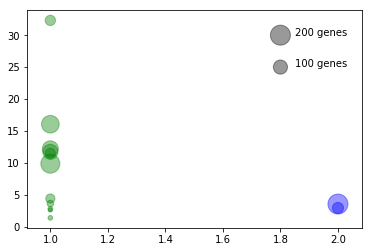

In [7]:
#this script plots the results of the GO analysis
#read in the results file
GO = pd.read_csv('fast_slow_GO.tsv', sep='\t')

#count the number of genes for each entry
gene_counts = []
for rowno in range(GO.shape[0]):
    this_gene_string = GO['genes'][rowno]
    this_gene_count = len(this_gene_string.split(","))
    gene_counts.append(this_gene_count)

scale_factor = 2
gene_counts = [y*scale_factor for y in gene_counts]
    
#plot the GO term p-values. Plots at position 1 are for fast genes, at position 2 for slow genes.
plt.close()
y = [-log(y,10) for y in GO['adj_pval']]
plt.scatter(x=GO['category'], y=y,color=GO['plot_color'], s=gene_counts, alpha = 0.4)
plt.scatter(x=[1.8,1.8],y=[30,25], color='black', s=[400,200], alpha = 0.4)
plt.text(1.85,30, '200 genes')
plt.text(1.85,25, '100 genes')
#plt.savefig('GO_process.svg')
plt.show()